A classificação de dígitos escritos a mão é um problema clássico de machine learning, que possue muitas utilidades práticas como automatizar o depósito através de cheques no banco e detectar o endereço para o qual um pacote deve ser enviado (no correio). Com isso em mente, nos fazemos as perguntas: É possível utilizar técnicas de clusterização para classificar dígitos? Se sim, até qual taxa de eficiência conseguimos chegar?

In [17]:
import random
from base64 import b64decode
from json import loads
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

In [18]:
def ler(x):

    digit = loads(x)
    array = np.fromstring(b64decode(digit["data"]),dtype=np.ubyte)
    array = array.astype(np.float64)
    return (digit["label"], array)

In [19]:
#Lemos o dataset e criamos uma lista com todos os valores
with open("digits.base64.json","r") as f:
    digits = map(ler, f.readlines())
digits=list(digits)

O dataset aqui utilizado foi o MNIST, que é a escolha padrão para problemas de classificação de dígitos em machine learning. Esse dataset possúi 60000 dígitos escritos a mão em grids de 28 por 28 pixeis. Eles vem no formato de vetores de 784 posições, cada uma de suas casas contendo um valor entre 0 (branco) e 255 (preto), que representa a intensidade daquele pixel. Esse dataset também vem com o real valor do dígito, já classificado por um ser humano. Utilizaremos isso mais tarde no código para nomear as clusters e medir a performance de nosso algorítimo.

In [20]:
#Definimos uma função que transforma os vetores com os pixeis em uma imagem
#com o digito. Usaremos essa função para observar as centróides de cada
#cluster, ver quais dígitos falharam em ser reconhecidos e, em geral, entender
#o que está sendo feito pelo programa
def display_digit(digit, labeled = True, title = ""):
    if labeled:
        digit = digit[1]
    image = digit
    plt.figure()
    fig = plt.imshow(image.reshape(28,28))
    fig.set_cmap('gray_r')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if title != "":
        plt.title("Inferred label: " + str(title))

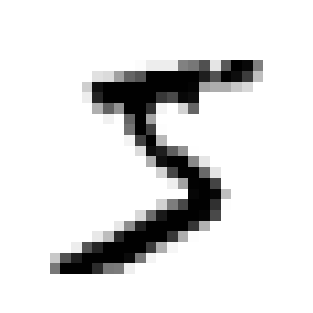

In [21]:
display_digit(digits[0])

In [22]:
#Criamos uma nova lista que armazenará apenas a informação dos pixeis
#de cada dígito
new_digits=[]
cont=0
while cont<len(digits):
    new_digits.append(digits[cont][1])
    cont+=1

In [23]:
#Aqui, separamos o dataset em dois pedaços. O primeiro pedaço dele será usado
#mais tarde para "nomear" cada cluster, dando a ela o nome do dígito que apareceu
#com maior frequencia. O segundo pedaço do dataset será usado para medir a taxa de
#acerto do programa
digits_treino=digits[:len(digits)*5//6]
digits_val=digits[len(digits)*5//6:]
new_digits_treino=new_digits[:len(new_digits)*5//6]
new_digits_val=new_digits[len(new_digits)*5//6:]

In [24]:
#Usamos o KMeans do sklearn para descobrir as clusters
n=10
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
#Criamos uma lista com o index da cluster à qual cada dígito pertence
#Criamos também uma lista com os centros de cada cluster
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
clus

array([3, 2, 7, ..., 3, 6, 4])

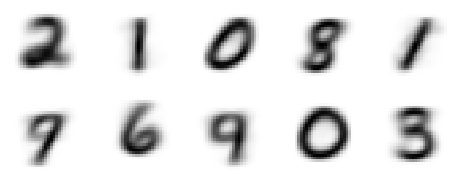

In [26]:
#Encontramos os pontos mais próximos dos centros de cada cluster e plotamos eles,
#para que seja possível ter uma ideia da forma dos números que estão em cada
#cluster. Idealmente, cada cluster só conteria dígitos que são os mesmos que seus
#centros
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = centers.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [27]:
def acha_nome(i):
    valores=[0,0,0,0,0,0,0,0,0,0]
    cont=0
    while cont<len(digits_treino):
        if clus[cont]==i:
            valores[digits_treino[cont][0]]=valores[digits_treino[cont][0]]+1
        cont=cont+1
    m=max(valores)
    cont=0
    while cont<len(valores):
        if m==valores[cont]:
            return cont
        cont=cont+1

In [28]:
#Utilizamos a função para encontrar o dígito mais frequente, usando apenas
#aqueles que estão na lista digits_treino. Nomeamos a cluster com esse dígito.
#Criamos a lista valores que, ao receber o index da cluster, retorna seu nome
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
nomes

array([2, 1, 0, 8, 1, 7, 6, 4, 0, 3])

In [29]:
#Agora, com as clusters nomeadas, utilizaremos a lista digits_val para conferir 
#o real valor do dígito com o nome da cluster a ele associado
gt=[]
clus_nome=[]
cont=0
while cont<len(digits_val):
    gt.append(digits_val[cont][0])
    clus_nome.append(nomes[clus[cont+50000]])
    cont=cont+1

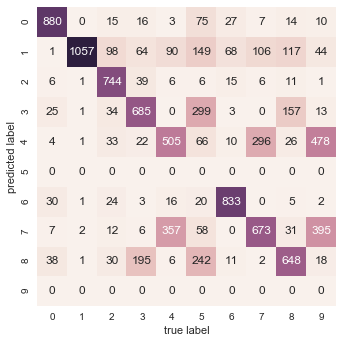

In [30]:
#Criamos uma confusion matrix, que nos mostra os erros e acertos das clusters
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');

In [31]:
#Escrevemos, agora, um código que nos dirá a porcentamge dos acertos
def taxa(mat):
    acertos=0
    cont=0
    while cont<10:
        acertos += mat[cont][cont]
        cont += 1
    taxa = acertos/10000
    return taxa

In [32]:
taxa(mat)

0.60250000000000004

Vemos, assim, que nosso programa já é capaz de agrupar os dígitos na maior parte das vezes. Ainda podemos, no entanto, melhorar bastante sua performance. Olhando para a confusion matrix, é fácil perceber um grave problema: cincos e noves nunca foram corretamente classificados. Olhando para a lista com os "nomes" das clusters e para as imagens dos centros, encontramos o motivo: nenhuma cluster foi classificada como "5" ou como "9", apesar de dois dos centros serem noves. As clusters desses centros receberam os nomes de 7 e 4, que de fato se assemelham à forma dos noves da imagem. Também vemos que dois dos centros são uns e outros dois são zeros. Isso ocorre porque existem mais do que uma forma de desenhar certos dígitos. Nossa decisão inicial de aplicar o k-means com apenas 10 clusters acabou comprometendo a performance do programa. No entando, não há como contar quantas formas de escrever cada dígito existem, até porque essa classificação é bem subjetiva.

Fazemos, a seguir, um estudo de performance em relação ao número de clusters:

In [81]:
n=10
perf=[]
while n<51:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits_val):
        gt.append(digits_val[cont][0])
        clus_nome.append(nomes[clus[cont+50000]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf.append(taxa(mat))
    n+=1
perf

[0.60229999999999995,
 0.60309999999999997,
 0.61629999999999996,
 0.63149999999999995,
 0.67259999999999998,
 0.69210000000000005,
 0.70199999999999996,
 0.72199999999999998,
 0.71830000000000005,
 0.72440000000000004,
 0.72640000000000005,
 0.73070000000000002,
 0.74099999999999999,
 0.72740000000000005,
 0.74990000000000001,
 0.75439999999999996,
 0.75649999999999995,
 0.76459999999999995,
 0.76880000000000004,
 0.76990000000000003,
 0.77810000000000001,
 0.77100000000000002,
 0.77100000000000002,
 0.78969999999999996,
 0.77390000000000003,
 0.79459999999999997,
 0.77080000000000004,
 0.79920000000000002,
 0.81030000000000002,
 0.80430000000000001,
 0.81820000000000004,
 0.81320000000000003,
 0.82020000000000004,
 0.81279999999999997,
 0.82050000000000001,
 0.81189999999999996,
 0.82999999999999996,
 0.82369999999999999,
 0.82930000000000004,
 0.83220000000000005,
 0.82050000000000001]

In [83]:
n=60
perf2=[]
while n<101:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(new_digits)
    clus=kmeans.predict(new_digits)
    nomes=np.arange(0,n)
    cont=0
    while cont<len(nomes):
        nomes[cont]=acha_nome(cont)
        cont=cont+1
    gt=[]
    clus_nome=[]
    cont=0
    while cont<len(digits_val):
        gt.append(digits_val[cont][0])
        clus_nome.append(nomes[clus[cont+50000]])
        cont=cont+1
    mat = confusion_matrix(gt, clus_nome)
    perf2.append(taxa(mat))
    n+=10
perf2

[0.85350000000000004,
 0.87050000000000005,
 0.88539999999999996,
 0.87860000000000005,
 0.88880000000000003]

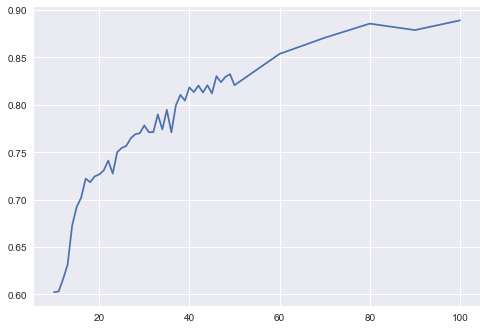

In [91]:
perf3=perf+perf2
a=np.arange(10,51)
b=np.arange(60,110,10)
c=list(a)+list(b)
plt.plot(c,perf3)

O gráfico acima mostra a performance que o algorítimo obteve para um dado número de clusters. Os valores obtidos ocilam um pouco mas, no geral, crescem. Esse crescimento se torna cada vez mais lento, mas não foi possível observar um número de clusters a partir do qual a performance começa a cair. O tempo do algorítimo fica muito lento para uma grande quantidade de clusters. A melhor performance obtida foi de 88,9% e ocorreu usando 100 clusters.

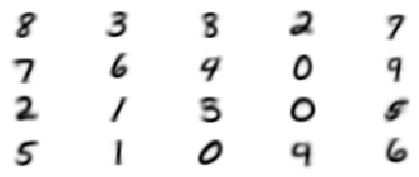

In [92]:
n=20
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(4, 5, figsize=(8, 3))
centers = centers.reshape(20, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

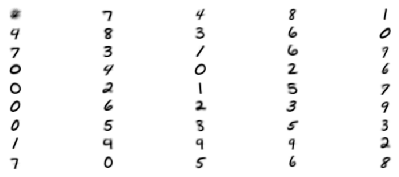

In [36]:
n=45
kmeans = KMeans(n_clusters=n)
kmeans.fit(new_digits)
clus=kmeans.predict(new_digits)
centers = kmeans.cluster_centers_
fig, ax = plt.subplots(9, 5, figsize=(8, 3))
centers = centers.reshape(45, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)


Vemos aqui, para 45 clusters, os centros. De acordo com o que esperávamos, os 
centros parecem tomar a forma de jeitos comuns de se escrever cada dígito. 
Parece que à medida que tomamos mais e mais clusters para rodar o algorítmo,
obtemos mais centros que correspondem a uma forma específica de se escrever
cada dígito, assim aumentando a chance daquele dígito ser corretamente classificado.

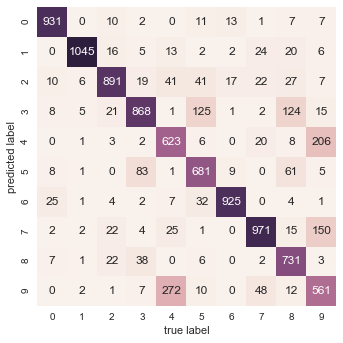

In [39]:
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
gt=[]
clus_nome=[]
cont=0
while cont<len(digits_val):
    gt.append(digits_val[cont][0])
    clus_nome.append(nomes[clus[cont+50000]])
    cont=cont+1
nomes=np.arange(0,n)
cont=0
while cont<len(nomes):
    nomes[cont]=acha_nome(cont)
    cont=cont+1
mat = confusion_matrix(gt, clus_nome)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.arange(0,10),
            yticklabels=np.arange(0,10))
plt.xlabel('true label')
plt.ylabel('predicted label');

Plotando a confusion matrix para 45 clusters, percebemos que o número de acertos já se tornou bem maior, mas que ainda existem alguns casos específicos em que o algorítimo parece errar com frequência. O caso mais notável é o de quatros sendo classificados como noves.

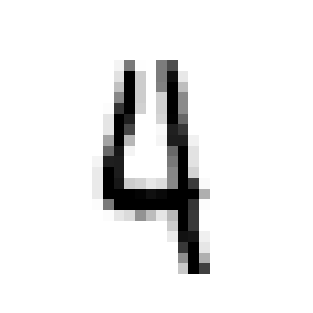

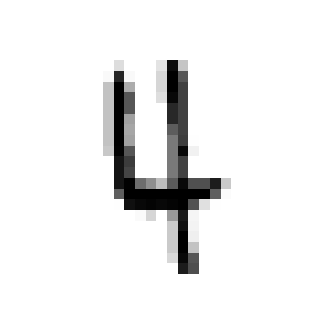

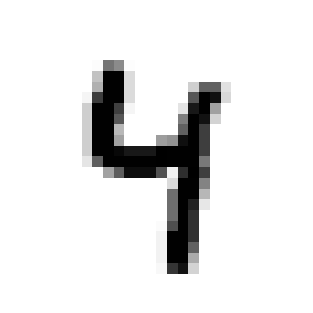

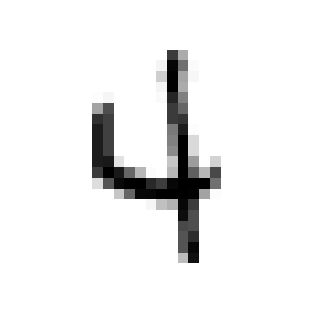

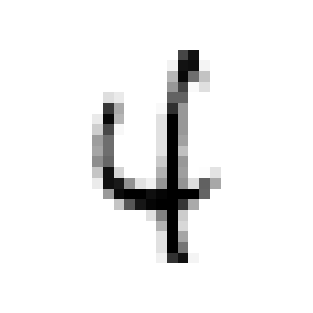

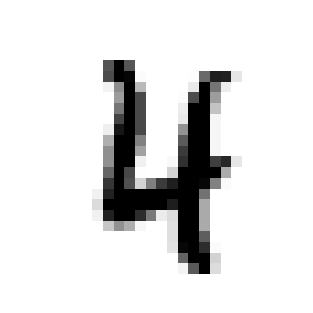

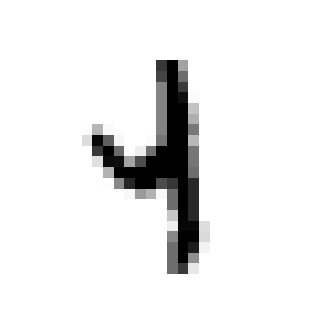

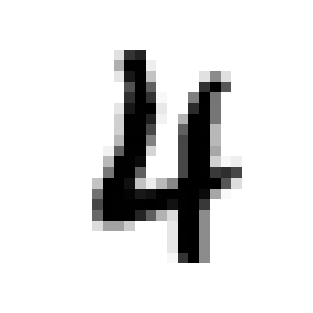

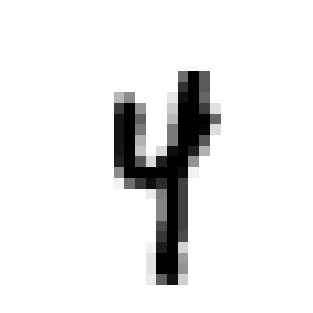

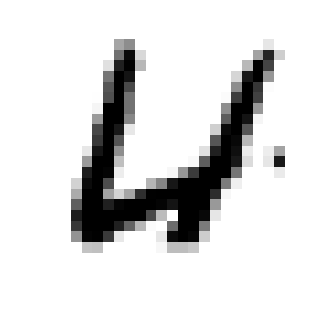

In [40]:
cont=0
m=0
wrong_digits=[]
while m<10:
    if gt[cont]!=clus_nome[cont] and gt[cont]==4:
        wrong_digits.append(digits[cont+50000])
        display_digit(digits[cont+50000])
        m+=1
    cont+=1

Plotando alguns dos quatros que foram classificados como noves, o motivo para o erro fica mais aparente: muitos desses quatros foram mal desenhados e, além disso, todos eles são muito próximos de um nove, a única diferença entre eles sendo que nos quatros a curva no topo não se fecha. Observando os centros desse caso, notamos que existem poucos quatros. É possível especular que, caso o algorítimo fosse rodado com mais clusters, surgiriam mais quatros como centros, o que poderia fazer com que muitos dos casos exibidos acima pudessem ser compreendidos como quatros, ao invés de serem identificados como noves por terem formas mais curvas.

Além de adicionar mais clusters, poderíamos tentar aumentar a performance do algorítimo utilizando outra técnica de clusterização ou mesmo alguma técnica de classificação diferente. A utilização de redes neurais para a classificação de dígitos escritos a mão é especialmente eficiente.